<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [3]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [5]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2023-08-11 21:18:54--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2023-08-11 21:18:54--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.001s  

2023-08-11 21:18:54 (37.5 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2023-08-11 21:18:54--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.001s (37.5 MB/s)


In [6]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 7.8 MB/s eta 0:00:00


In [7]:
from torch_helpers import binary_acc
from torchmetrics.functional import f1_score

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            #print(type(output))
            #print(type(train_target))

            #output = output.type(torch.int64)
            #train_target = train_target.type(torch.int64)
            accuracy = binary_acc(output, train_target)#f1_score(output, train_target).item() #f1_score(output, train_target) #binary_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy#.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        #valid_target = valid_target.type(torch.int64)
        #output = output.type(torch.float64)
        epoch_valid_accuracy = binary_acc(output, valid_target).item()#f1_score(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset críticas de películas de IMDB puntuadas deforma positiva o negativa.
Referencia del dataset: [LINK](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [8]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 21.3MB/s]


In [9]:
# Armar el dataset
df_ = pd.read_csv('clothing_ecommerce_reviews.csv')
df = df_[["Review Text", "Rating"]]

### 1 - Limpieza de datos
- En los datos se observo que en la columna "review" hay código HTML de salto de línea.
- Tranformar la columna snetiment a 0 y 1



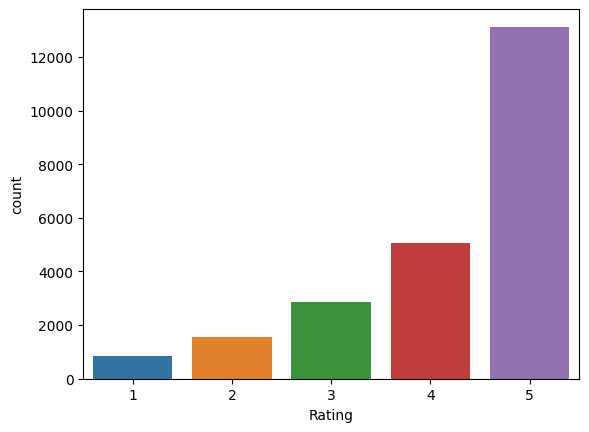

In [10]:
sns.countplot(x='Rating', data=df)
plt.show()

In [11]:
# En los datos se observó código de HTML de salto de línea <br />
import re


df["Rating"].replace({2: 1}, inplace=True)
df["Rating"].replace({3: 1}, inplace=True)
df["Rating"].replace({4: 2}, inplace=True)
df["Rating"].replace({5: 2}, inplace=True)
df["Rating"] = df["Rating"] -1
df_reviews = df.copy()
df_reviews.head()

<ipython-input-11-0bd4d06951fd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"].replace({2: 1}, inplace=True)
<ipython-input-11-0bd4d06951fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"].replace({3: 1}, inplace=True)
<ipython-input-11-0bd4d06951fd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"].replace({4: 2}, inplace=True)
<ipython-input-11-0bd4d06951fd>:8: SettingWithCopyWarning: 
A value

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [12]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()

1    18208
0     5278
Name: Rating, dtype: int64

Se puede observar que el dataset está perfectamente balanceado

In [13]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(23486,)

In [14]:
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

23486

In [15]:
cont = 0
for k in text_sequences:
  if type(k) != str :
    text_sequences[cont] = " "#str(k)
  cont = cont + 1

In [16]:
text_sequences[92]

' '

In [17]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [18]:
# ¿Cuál es la longitud de ese corpus?
len(corpus)

7013333

In [19]:
# Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from torch_helpers import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [20]:
# Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [21]:
# ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [22]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(tokens)

In [23]:
# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [24]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [25]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [26]:
# Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [27]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from torch_helpers import pad_sequences
maxlen = 200

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [28]:
# Observar las dimensiones de la variable input
X.shape

(23486, 200)

In [29]:
# Tomar la columna rating y alcemacenarla en una variable "y"
# Su shape debe ser equivalente la cantidad de rows del corpus
y = df_reviews['Rating'].values
print(y.shape)

(23486,)


In [30]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # la loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 200
Output dim 1


In [31]:
# Utilizamos "random_split" para crear los datos de train y test
# partir del conjunto de datos_set
# Fijamos un "seed" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
torch.manual_seed(42)
data_set_reduced_size = int(data_set.len * 0.4)
valid_set_size = int(data_set_reduced_size * 0.2)
train_set_size = data_set_reduced_size - valid_set_size
data_set_reduced, _ = torch.utils.data.random_split(data_set, [data_set_reduced_size, data_set.len - data_set_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_reduced, [train_set_size, data_set_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Tamaño del conjunto de entrenamiento: 7516
Tamaño del conjunto de validacion: 1878


### 2 - Entrenar el modelo con Embeddings + LSTM

Embeddings Fasttext + LSTM

In [32]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
From (redirected): https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download&confirm=t&uuid=d7685130-79db-4ef3-9e25-24e1ca10a157
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:19<00:00, 147MB/s]


In [33]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [34]:
model_fasttext = FasttextEmbeddings()

In [35]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [36]:
class Model2(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size
        # embedding_dim = 300 --> dimensión de los embeddings utilizados
        self.lstm_size = 64
        self.num_layers = 5
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.3) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=output_dim) # Fully connected layer

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

model2 = Model2(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.BCELoss()   # Para clasificación multiclase

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 1]                    --
├─Embedding: 1-1                         [1, 200, 300]             (600,000)
├─LSTM: 1-2                              [1, 200, 64]              226,816
├─Linear: 1-3                            [1, 128]                  8,320
├─ReLU: 1-4                              [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 1]                    129
├─Sigmoid: 1-7                           [1, 1]                    --
Total params: 835,265
Trainable params: 235,265
Non-trainable params: 600,000
Total mult-adds (M): 45.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.58
Params size (MB): 3.34
Estimated Total Size (MB): 3.93

In [37]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=50
                )

Epoch: 1/50 - Train loss 0.543 - Train accuracy 0.770 - Valid Loss 0.508 - Valid accuracy 0.812
Epoch: 2/50 - Train loss 0.535 - Train accuracy 0.775 - Valid Loss 0.494 - Valid accuracy 0.812
Epoch: 3/50 - Train loss 0.534 - Train accuracy 0.775 - Valid Loss 0.473 - Valid accuracy 0.844
Epoch: 4/50 - Train loss 0.536 - Train accuracy 0.775 - Valid Loss 0.539 - Valid accuracy 0.781
Epoch: 5/50 - Train loss 0.535 - Train accuracy 0.775 - Valid Loss 0.334 - Valid accuracy 0.938
Epoch: 6/50 - Train loss 0.535 - Train accuracy 0.775 - Valid Loss 0.575 - Valid accuracy 0.750
Epoch: 7/50 - Train loss 0.536 - Train accuracy 0.775 - Valid Loss 0.564 - Valid accuracy 0.750
Epoch: 8/50 - Train loss 0.527 - Train accuracy 0.775 - Valid Loss 0.509 - Valid accuracy 0.812
Epoch: 9/50 - Train loss 0.515 - Train accuracy 0.775 - Valid Loss 0.586 - Valid accuracy 0.750
Epoch: 10/50 - Train loss 0.502 - Train accuracy 0.775 - Valid Loss 0.441 - Valid accuracy 0.812
Epoch: 11/50 - Train loss 0.488 - Train

In [38]:
h = []
for t in history2['accuracy']:
    h.append(t.item())

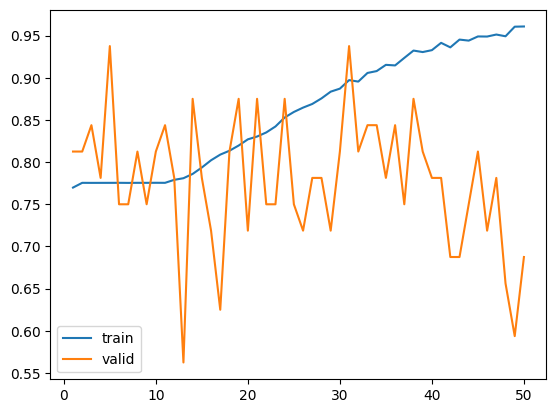

In [39]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=h, label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

##Conclusión
Tomamos ratings entre 1-3 como malos, ya que 1 lo mas negativo, 2 es algo malo pero que me hizo saber que existe algo malo y gracias por ello, 3 es una puntuación mediocre, por lo que 4 y 5 son los mejores resultados para este caso.

La mejor cantidad de epochs bajo esta arquitectura son no mas de 31, ya que para la epoch 50 el modelo sobre entrenó:

Epoch: 50/50 - Train loss 0.122 - Train accuracy 0.961 - Valid Loss 1.202 - Valid accuracy 0.688

vs

Epoch: 31/50 - Train loss 0.263 - Train accuracy 0.897 - Valid Loss 0.251 - Valid accuracy 0.938



